In [1]:
import pandas as pd
import numpy as np
import glob
import datetime
import heapq as heap
from os.path import basename
# Imports to use TensorFlow
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# Imports to graph t-SNE
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
# Imports for xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score
# Imports for Elapsed Time Prediction
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV

# Pandas options
pd.options.display.max_columns = 1200
pd.options.display.max_rows = 1200

Instructions for updating:
non-resource variables are not supported in the long term


# Section 1: Combine Tracklib and Cobalt DJC logs

If you have already run Section 1, or have an existing copy of the combined `.csv`, skip to **Section 2**.

In [47]:
# Read in TrackLib dataset
libdf = pd.read_csv('../data/tracklib/tracklib_mira_20200227.csv')

In [50]:
# Read in Cobalt logs dataset
djc_df = pd.read_csv('../data/tracklib/mira_djc_complete/dim_job_composite.csv')

In [86]:
# Take cobalt logs and add a column for each short library name
df = djc_df.assign(**dict.fromkeys(libdf.LIB_SHORT_NAME.unique(), 0))

COBALT_JOBID  QUEUED_DATE_ID  START_DATE_ID   END_DATE_ID  \
count  2.763140e+05    2.763140e+05   2.763140e+05  2.763140e+05   
mean   1.046564e+06    2.016660e+07   2.016663e+07  2.016663e+07   
std    5.344312e+05    1.365261e+04   1.364564e+04  1.364466e+04   
min    3.522200e+05    2.014103e+07   2.014123e+07  2.015010e+07   
25%    6.183280e+05    2.015093e+07   2.015093e+07  2.015093e+07   
50%    9.727955e+05    2.016120e+07   2.016121e+07  2.016121e+07   
75%    1.538465e+06    2.018051e+07   2.018051e+07  2.018051e+07   
max    9.999000e+07    2.019073e+07   2.019073e+07  2.019073e+07   

       WALLTIME_SECONDS  RUNTIME_SECONDS     NODES_USED  NODES_REQUESTED  \
count     276314.000000    276314.000000  276314.000000    276314.000000   
mean       11508.103838      7349.374773    2053.188300      2013.286880   
std        14334.547058     11750.518818    4310.332276      4307.036097   
min          180.000000        15.000000       0.000000         1.000000   
25%         2400.000000       425.000000     512.000000       512.000000   
50%         6000.000000      2666.000000     512.000000       512.000000   
75%        18000.000000      9563.000000    2048.000000      2048.000000   
max       217200.000000    217243.000000   49152.000000     49152.000000   

          CORES_USED  CORES_REQUESTED  ...       gsl    netcdf  valgrind  \
count  276314.000000    276314.000000  ...  276314.0  276314.0  276314.0   
mean    32851.012804     32212.590082  ...       0.0       0.0       0.0   
std     68965.316411     68912.577552  ...       0.0       0.0       0.0   
min         0.000000        16.000000  ...       0.0       0.0       0.0   
25%      8192.000000      8192.000000  ...       0.0       0.0       0.0   
50%      8192.000000      8192.000000  ...       0.0       0.0       0.0   
75%     32768.000000     32768.000000  ...       0.0       0.0       0.0   
max    786432.000000    786432.000000  ...       0.0       0.0       0.0   

       essl_fftw      silo   bgclang      essl   darshan    scorep     metis  
count   276314.0  276314.0  276314.0  276314.0  276314.0  276314.0  276314.0  
mean         0.0       0.0       0.0       0.0       0.0       0.0       0.0  
std          0.0       0.0       0.0       0.0       0.0       0.0       0.0  
min          0.0       0.0       0.0       0.0       0.0       0.0       0.0  
25%          0.0       0.0       0.0       0.0       0.0       0.0       0.0  
50%          0.0       0.0       0.0       0.0       0.0       0.0       0.0  
75%          0.0       0.0       0.0       0.0       0.0       0.0       0.0  
max          0.0       0.0       0.0       0.0       0.0       0.0       0.0  

[8 rows x 80 columns]

In [100]:
# One-hot encode library names into djc_df
# THIS IS VERY INEFFICIENT, DON'T RUN UNLESS YOU NEED TO.
# TAKES ~1 hour to run on flick 🙃
for lib in libdf.LIB_SHORT_NAME.unique():
    temp_df = libdf[libdf['LIB_SHORT_NAME'] == lib]
    temp_df.set_index('COBALT_JOBID', inplace=True)
    def helper(row):
        if row['COBALT_JOBID'] in temp_df.index:
            row[lib] = 1
            return row
        else:
            return row
    df = df.apply(helper, axis=1)

In [103]:
# Write it out to .csv so we don't have to run this terribly inefficient
# code every time
df.to_csv('../data/tracklib/tracklib_djc.csv')

# Section 2: Clean and Filter Combined Dataset

If you already have a filtered `.csv` you want to use, skip to **Section 3**.

* Parameters:
    * n
        * Number of top corehours consumers to include
        * Possible values: >=0
        * Set to 0 to include all of them

In [309]:
# Parameters
n = 50

In [310]:
# Read in the various dataframes if you need to
df = pd.read_csv('../data/tracklib/tracklib_djc.csv', header=0, low_memory=False)
libdf = pd.read_csv('../data/tracklib/tracklib_mira_20200227.csv')
djc_df = pd.read_csv('../data/mira_djc_complete/dim_job_composite.csv')

In [311]:
# Drop Nans and weird column 
df.drop('Unnamed: 0', axis=1, inplace=True)
df.dropna(axis=0, how='any', inplace=True)

In [312]:
# Filter combined dataset based on date overlap
df = df[df.START_TIMESTAMP > libdf.START_TIMESTAMP.min()]

In [313]:
# Add a column for an executable name/project name feature
def exec_maker(row):
    return str('%s.%s' % (row['PROJECT_NAME'], basename(row['COMMAND']))) 

df['EXEC'] = df.apply(exec_maker, axis=1)

In [314]:
# Filter by top n core hour consumers
# df_filtered = pd.DataFrame()
# if n > 0:
#     names = df.EXEC.unique()
#     core_hours_dict = {}
#     for name in names:
#         core_hours_dict.update({name : df.USED_CORE_HOURS.sum()})
#     top_names = heap.nlargest(n, core_hours_dict, key=core_hours_dict.get)
#     for name in top_names:
#         df_filtered = df_filtered.append(df[df['EXEC'] == name])
# else:
#     df_filtered = df.copy()

n_top_execs = df.EXEC.value_counts().head(n - 1)
df_filtered = df[df.EXEC.isin(n_top_execs.keys())]

In [315]:
# Save to a '.csv'
if n > 0:
    df_filtered.to_csv('../data/tracklib/tracklib_djc_filtered_' + str(n) + '.csv')
else:
    df_filtered.to_csv('../data/tracklib/tracklib_djc_filtered.csv')

# Section 3: TensorFlow Model

* Parameters:
    * m
        * number of top corehours consumers to include.
        * Possible values: >=0
        * Set to 0 to include all of them. 
        * Set to n to use the value from **Section 2**.
    * train_size
        * how much of the full dataset to use for training
        * Possible values: 0 to 1

In [627]:
# Parameters
m = 50
train_size = .80

In [628]:
# Read in the various dataframes if you need to
# df = pd.read_csv('../data/tracklib/tracklib_djc.csv')
# libdf = pd.read_csv('../data/tracklib/tracklib_mira_20200227.csv')
# djc_df = pd.read_csv('../data/mira_djc_complete/dim_job_composite.csv')
if m > 0:
    df_filtered = pd.read_csv('../data/tracklib/tracklib_djc_filtered_' + str(m) + '.csv')
else:
    df_filtered = pd.read_csv('../data/tracklib/tracklib_djc_filtered.csv')

In [629]:
df_filtered = df_filtered.sample(frac=1)

In [630]:
# Select features and targets to use for model
features = df_filtered.select_dtypes(include=[np.number]).copy()
features = features.drop([column for column in features.columns if features[column].max() == features[column].min()], axis=1)
features = features.drop([column for column in features.columns if 'ID' in column], axis=1)
features = features.drop([column for column in features.columns if 'unnamed' in column.lower()], axis=1)

targets = pd.DataFrame()
targets['number'] = pd.factorize(df_filtered['EXEC'])[0]

In [631]:
# # EXPERIMENT: Drop everthing except libraries
# features = features.drop([column for column in features.columns if 'NUM' in column], axis=1)
# features = features.drop([column for column in features.columns if 'SECONDS' in column], axis=1)
# features = features.drop([column for column in features.columns if 'USED' in column], axis=1)
# features = features.drop([column for column in features.columns if 'CORE' in column], axis=1)
# features = features.drop([column for column in features.columns if 'NODE' in column], axis=1)
# features = features.drop([column for column in features.columns if 'IS' in column], axis=1)
# features = features.drop([column for column in features.columns if 'EXIT' in column], axis=1)
# features = features.drop([column for column in features.columns if 'FACTOR' in column], axis=1)

# for columns in features.columns:
#     print(columns)

In [632]:
# # EXPERIMENT: Test without libraries
# features = features.drop([column for column in features.columns if column.islower()], axis=1)

In [633]:
# EXPERIMENT: Drop features we don't have access to before runtime
features = features.drop([column for column in features.columns if 'RUNTIME_SECONDS' in column], axis=1)
features = features.drop([column for column in features.columns if 'NODES_USED' in column], axis=1)
features = features.drop([column for column in features.columns if 'CORES_USED' in column], axis=1)
features = features.drop([column for column in features.columns if 'EXIT_STATUS' in column], axis=1)
features = features.drop([column for column in features.columns if 'USED_CORE_HOURS' in column], axis=1)
features = features.drop([column for column in features.columns if 'COBALT_NUM_TASKS' in column], axis=1)
features = features.drop([column for column in features.columns if 'ELIGIBLE' in column], axis=1)
features = features.drop([column for column in features.columns if 'QUEUED' in column], axis=1)
features = features.drop([column for column in features.columns if 'USAGE' in column], axis=1)
features = features.drop([column for column in features.columns if 'EXIT_CODE' in column], axis=1)
features = features.drop([column for column in features.columns if 'NUM_TASK' in column], axis=1)
features = features.drop([column for column in features.columns if 'IS_' in column], axis=1)

features.columns

Index(['WALLTIME_SECONDS', 'NODES_REQUESTED', 'CORES_REQUESTED',
       'REQUESTED_CORE_HOURS', 'OVERBURN_CORE_HOURS', 'boost',
       'bgsys-gnu-linux', 'bgsys-gnu-linux-4.7.2', 'autoperf', 'blas',
       'bgsys-comm', 'bgsys-hwi', 'ibmcmp', 'bgsys-bgpm', 'bgsys-spi',
       'qmcpack', 'pnetcdf', 'bgsys-cnk', 'fftw', 'zlib', 'scalapack', 'hdf5',
       'gcc', 'lapack', 'netcdf', 'essl_fftw', 'bgclang', 'essl', 'darshan'],
      dtype='object')

In [634]:
# Normalize features between 0 and 1 - plays nice with our neural network
# features = ((features - features.mean()) / (features.max() - features.min()))

In [635]:
# Separate our data into training and test sets
train_examples = features.head(int(len(df_filtered.index) * train_size))
train_targets = targets.head(int(len(df_filtered.index) * train_size))
test_examples = features.tail(int(len(df_filtered.index) * (1-train_size)))
test_targets = targets.tail(int(len(df_filtered.index) * (1-train_size)))

In [636]:
# Define our TensorFlow model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256, activation='relu', input_shape=(len(features.columns.values),)),
  tf.keras.layers.Dense(128, activation='relu', input_shape=(1,)),
  tf.keras.layers.Dense(128, activation='relu', input_shape=(1,)),
  tf.keras.layers.Dense(128, activation='relu', input_shape=(1,)),
  tf.keras.layers.Dense(targets.number.unique().size, activation='softmax')
])

In [637]:
# Compile our model
model.compile(optimizer=tf.train.AdagradOptimizer(0.05),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'],
            )

In [638]:
# Train model
model.fit(train_examples,
          train_targets,
          epochs=10,
         )

Train on 67915 samples
Epoch 1/10
67915/67915 [==============================] - 3s 51us/sample - loss: 63.4221 - sparse_categorical_accuracy: 0.0866
Epoch 2/10
67915/67915 [==============================] - 3s 50us/sample - loss: 3.7167 - sparse_categorical_accuracy: 0.0862
Epoch 3/10
67915/67915 [==============================] - 3s 50us/sample - loss: 3.7163 - sparse_categorical_accuracy: 0.0862
Epoch 4/10
67915/67915 [==============================] - 3s 50us/sample - loss: 3.7162 - sparse_categorical_accuracy: 0.0862
Epoch 5/10
67915/67915 [==============================] - 3s 50us/sample - loss: 3.7162 - sparse_categorical_accuracy: 0.0862
Epoch 6/10
67915/67915 [==============================] - 3s 49us/sample - loss: 3.7162 - sparse_categorical_accuracy: 0.0862
Epoch 7/10
67915/67915 [==============================] - 3s 49us/sample - loss: 3.7161 - sparse_categorical_accuracy: 0.0862
Epoch 8/10
67915/67915 [==============================] - 3s 49us/sample - loss: 3.7161 - spar

In [639]:
# Calculate Test Accuracy to make sure we haven't overfit
test_acc = model.evaluate(test_examples, test_targets)
print('Test accuracy:', test_acc)

16978/16978 [==============================] - 1s 32us/sample - loss: 3.7163 - sparse_categorical_accuracy: 0.0877
Test accuracy: [3.716336544136625, 0.08770173]


# Section 4: T-SNE Model

Use Zhengchung's t-sne plotting code to make a half-decent plot of a T-SNE representation.

In [42]:
# Read in the various dataframes if you need to
# df = pd.read_csv('../data/tracklib/tracklib_djc.csv')
# libdf = pd.read_csv('../data/tracklib/tracklib_mira_20200227.csv')
# djc_df = pd.read_csv('../data/mira_djc_complete/dim_job_composite.csv')
if m > 0:
    df_filtered = pd.read_csv('../data/tracklib/tracklib_djc_filtered_' + str(m) + '.csv')
else:
    df_filtered = pd.read_csv('../data/tracklib/tracklib_djc_filtered.csv')

In [43]:
features = df_filtered.select_dtypes(include=[np.number]).copy()
features = features.drop([column for column in features.columns if features[column].max() == features[column].min()], axis=1)
features = features.drop([column for column in features.columns if 'ID' in column], axis=1)

In [44]:
# Train T-SNE
X_embedded = TSNE().fit_transform(features)
X_embedded.shape

(7071, 2)

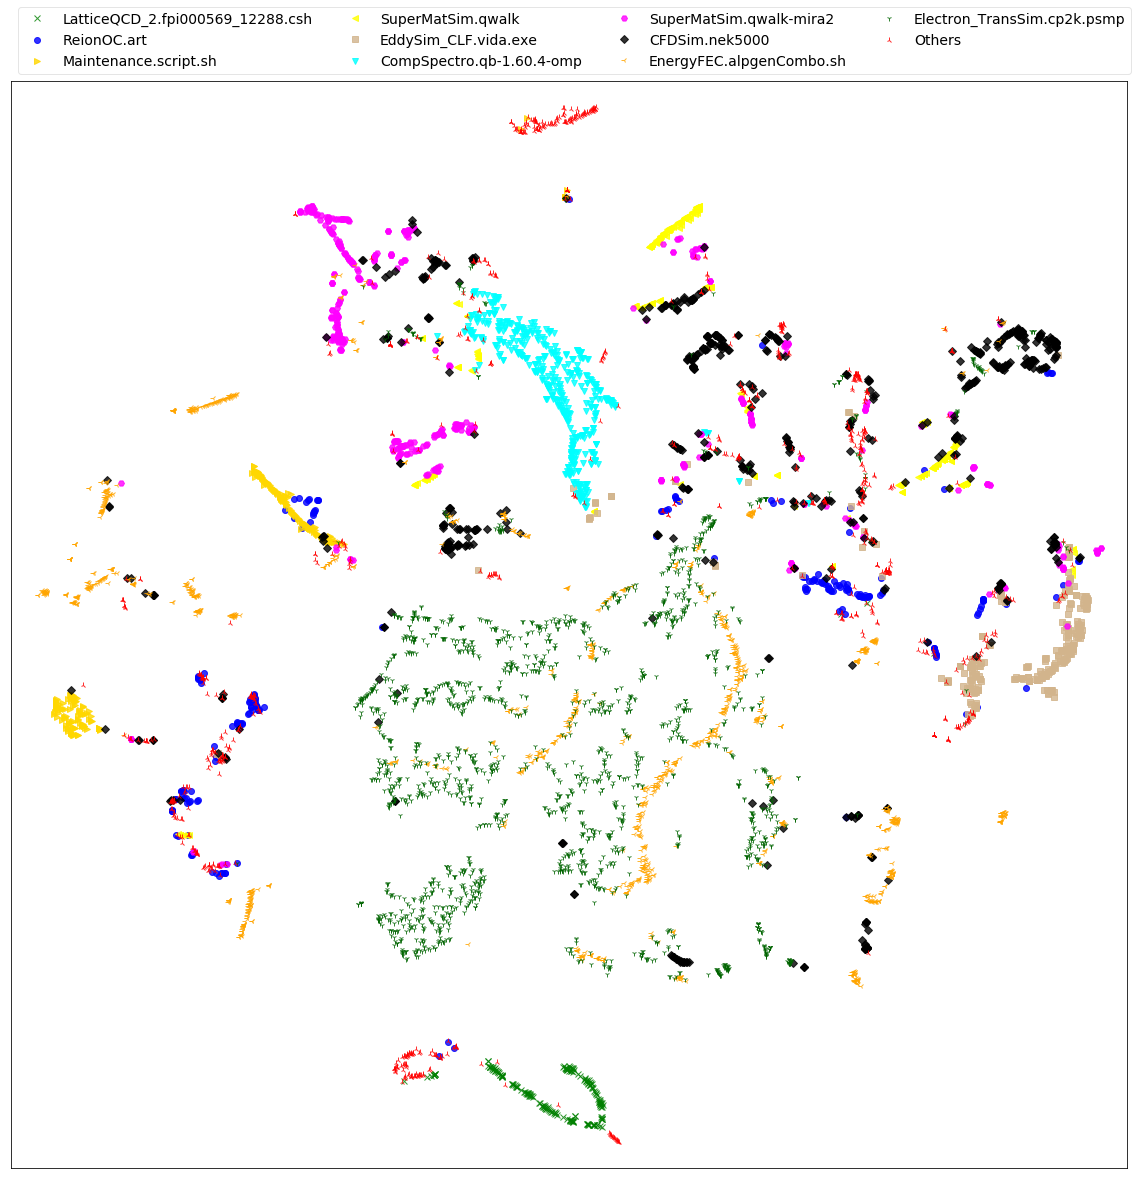

In [45]:
def t_sne_vis_by_group(x_emb, exe_idn, topn=10):
    idn_unique, idn_count = np.unique(exe_idn, return_counts=True)
    top_idn = idn_unique[np.argsort(idn_count)[-topn:]]
    plt.figure(figsize=(20, 20))
    colors = ('g', 'b', 'gold', 'yellow', 'tan', 'cyan', 'magenta', 'black', 'orange', 'darkgreen')
    markers= ('x', 'o', '>', '<', 's', 'v', 'H', 'D', '3', '1', '2')
    _other_grp = np.zeros(exe_idn.shape[0], dtype=np.bool)
    for _idx, _idn in enumerate(top_idn):
        _emb_grp = x_emb[exe_idn == _idn]
        plt.plot(_emb_grp[:, 0], _emb_grp[:, 1], markers[_idx], alpha=.8, color=colors[_idx], markersize=6, label = _idn)
        _other_grp |= (exe_idn == _idn)
#         print("%s is marked by %s and %s" % (_idn, colors[_idx], markers[_idx]))
    _uncat = x_emb[~_other_grp]
    plt.plot(_uncat[:, 0], _uncat[:, 1], markers[-1], alpha=.8, color='r', markersize=6, label = 'Others')
    
    plt.xlim(left=X_embedded[:, 0].min()*1.05, right=X_embedded[:, 0].max()*1.05)
    plt.ylim(bottom=X_embedded[:, 1].min()*1.05, top=X_embedded[:, 1].max()*1.05)
    plt.xticks([])
    plt.yticks([])
    plt.legend(bbox_to_anchor=(0., 1.0, 1., .102), ncol=4, loc=3, fancybox=True, framealpha=0.5, fontsize=14)
    plt.show()
    plt.close()
t_sne_vis_by_group(X_embedded, df_filtered['EXEC'].values)

# XGBoost Model

In [640]:
train_examples = features.head(int(len(df_filtered.index) * train_size))
train_targets = targets.head(int(len(df_filtered.index) * train_size))
test_examples = features.tail(int(len(df_filtered.index) * (1-train_size)))
test_targets = targets.tail(int(len(df_filtered.index) * (1-train_size)))

In [641]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", max_depth=10)
xgb_model.fit(train_examples, train_targets.values.ravel())

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [642]:
accuracy_score(test_targets, xgb_model.predict(test_examples))

0.8948050418188244

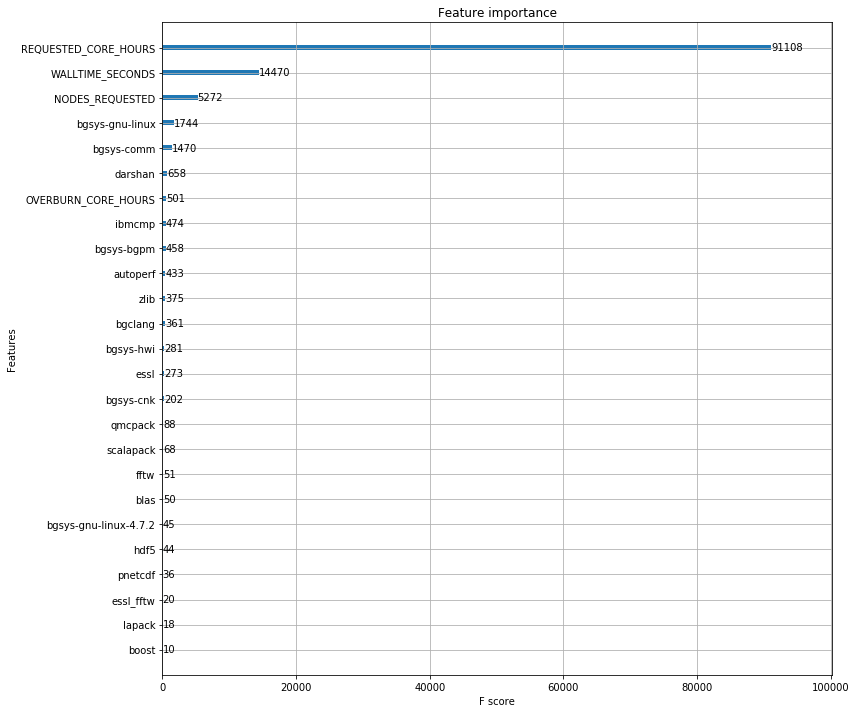

In [643]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
xgb.plot_importance(xgb_model, importance_type='weight', ax=ax)

In [644]:
df_filtered.EXEC.value_counts()

HiggsLHC.qhmc                             7345
LatticeQCD_3.run.512                      4204
HadronicLight_4.run-512.sh                3976
EnergyFEC.mcfm_omp                        3807
CSC249ADSE03.run.mira                     3317
LatticeQCD_3.himd6416_4lat.csh            3077
PSFMat.qmcpack                            2955
CSC249ADSE08.nek5000                      2897
LatticeQCD_3.run.mira                     2692
MIO_HP_2.aims.071914_7.scalapack.mpi.x    2470
LatticeQCD_2.himd6416_4lat.csh            2379
Electron_TransSim.cp2k.psmp               2036
EnergyFEC_2.mcfm_omp                      1726
NucleonEDM.script.sh                      1681
LaserMHD.flash4                           1678
LatticeQCD_3.qhmc                         1523
MoltenSalt.nek5000                        1465
LatticeQCD_3.run.2048                     1455
QCDMatter.dynqcd                          1428
QMCSim.qmcpack                            1380
EnergyFEC.alpgenCombo.sh                  1349
HadronicLight

In [645]:
len(features), len(features.drop_duplicates())

(84894, 41382)

In [646]:
# features.groupby(features.columns.tolist(),as_index=False).size()

In [647]:
features.columns

Index(['WALLTIME_SECONDS', 'NODES_REQUESTED', 'CORES_REQUESTED',
       'REQUESTED_CORE_HOURS', 'OVERBURN_CORE_HOURS', 'boost',
       'bgsys-gnu-linux', 'bgsys-gnu-linux-4.7.2', 'autoperf', 'blas',
       'bgsys-comm', 'bgsys-hwi', 'ibmcmp', 'bgsys-bgpm', 'bgsys-spi',
       'qmcpack', 'pnetcdf', 'bgsys-cnk', 'fftw', 'zlib', 'scalapack', 'hdf5',
       'gcc', 'lapack', 'netcdf', 'essl_fftw', 'bgclang', 'essl', 'darshan'],
      dtype='object')

# Elapsed Time Prediction

In [443]:
# Parameters
m = 20
train_size = .9

In [444]:
# Read in the various dataframes if you need to
# df = pd.read_csv('../data/tracklib/tracklib_djc.csv')
# libdf = pd.read_csv('../data/tracklib/tracklib_mira_20200227.csv')
# djc_df = pd.read_csv('../data/mira_djc_complete/dim_job_composite.csv')
if m > 0:
    df_filtered = pd.read_csv('../data/tracklib/tracklib_djc_filtered_' + str(m) + '.csv')
else:
    df_filtered = pd.read_csv('../data/tracklib/tracklib_djc_filtered.csv')

In [445]:
df_filtered = df_filtered[df_filtered.WALLTIME_SECONDS >= df_filtered.RUNTIME_SECONDS]

In [446]:
df_filtered = df_filtered[df_filtered['EXIT_STATUS'] == 0]

In [447]:
df_filtered = df_filtered.sample(frac=1)

In [448]:
len(df_filtered.index)

3692

In [449]:
features = pd.DataFrame()
features['WALLTIME_SECONDS'] = df_filtered['WALLTIME_SECONDS']
for column in df_filtered.columns:
    if column.islower():
        features[column] = df_filtered[column]

cols = ['USERNAME', 'PROJECT_NAME', 'QUEUE_NAME', 'EXEC', 'NODES_REQUESTED', 'REQUESTED_CORE_HOURS']
enc = OneHotEncoder(handle_unknown='ignore', sparse=False, categories='auto')
enc.fit(df_filtered[cols])
features = pd.concat([features.reset_index(drop=True), pd.DataFrame(enc.transform(df_filtered[cols]))], axis=1, join='inner')

targets = df_filtered.RUNTIME_SECONDS

In [450]:
# features

In [451]:
# Select features and targets to use for model
# features = df_filtered.select_dtypes(include=[np.number]).copy()
# features = features.drop([column for column in features.columns if features[column].max() == features[column].min()], axis=1)
# features = features.drop([column for column in features.columns if 'ID' in column], axis=1)
# features = features.drop([column for column in features.columns if 'unnamed' in column.lower()], axis=1)

# targets = df_filtered.RUNTIME_SECONDS

In [452]:
# # EXPERIMENT: Test without libraries
# features = features.drop([column for column in features.columns if str(column).islower()], axis=1)

In [453]:
# enc = LabelBinarizer()
# enc.fit(df_filtered.EXEC.values.reshape(-1, 1))
# encoding = enc.transform(df_filtered.EXEC.values.reshape(-1,1))
# features = pd.concat([features, pd.DataFrame(encoding)], axis=1)

In [454]:
train_examples = features.head(int(len(df_filtered.index) * train_size))
train_targets = targets.head(int(len(df_filtered.index) * train_size))
test_examples = features.tail(int(len(df_filtered.index) * (1-train_size)))
test_targets = targets.tail(int(len(df_filtered.index) * (1-train_size)))

In [455]:
paras = {'n_estimators'    :[100, 200, 300, 400, 500, 600, 1000][-3:],\
         'max_depth'       :[5, 10, 20, 30, 40, 50][-3:],} 

xgb_model = xgb.XGBRegressor()
grid = GridSearchCV(xgb_model, paras, n_jobs=16, cv=3)

grid.fit(train_examples, train_targets)

/home/luckierdodge/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
         

In [475]:
pred    = grid.best_estimator_.predict(test_examples)
error   = pred - test_targets
abs_err = np.abs(error)
rel_err = 100. * abs_err / test_targets
print(np.percentile(rel_err, 25), np.percentile(rel_err, 50), np.percentile(rel_err, 75), np.percentile(rel_err, 95))
print(np.percentile(abs_err, 25), np.percentile(abs_err, 50), np.percentile(abs_err, 75), np.percentile(abs_err, 95))

0.2505006252092751 1.7376230415942449 11.168471327773085 59.82784476846996
8.54931640625 61.0283203125 483.888671875 4414.680371093742


(array([359.,   5.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.84396242e-02, 3.09216311e+03, 6.18430778e+03, 9.27645246e+03,
        1.23685971e+04, 1.54607418e+04, 1.85528865e+04, 2.16450311e+04,
        2.47371758e+04, 2.78293205e+04, 3.09214652e+04, 3.40136098e+04,
        3.71057545e+04, 4.01978992e+04, 4.32900439e+04, 4.63821885e+04,
        4.94743332e+04, 5.25664779e+04, 5.56586225e+04, 5.87507672e+04,
        6.18429119e+04, 6.49350566e+04, 6.80272012e+04, 7.11193459e+04,
        7.42114906e+04, 7.73036353e+04, 8.03957799e+04, 8.34879246e+04,
        8.65800693e+04, 8.96722139e+04, 9.27643586e+04]),
 <a list of 30 Patch objects>)

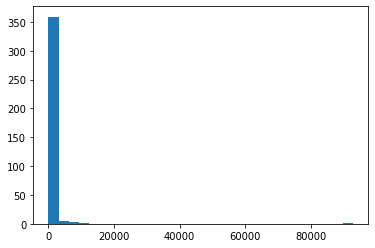

In [476]:
plt.hist(rel_err, bins=30)

In [477]:
top_feat_idx = np.argsort(grid.best_estimator_.feature_importances_)[-15:]
features.columns[top_feat_idx]

Index([                     54,                     186,
                          1548,                      46,
                        'essl',                  'blas',
                           266,                      66,
                   'bgsys-hwi',      'WALLTIME_SECONDS',
                             7,                      72,
                            16,                      18,
       'bgsys-gnu-linux-4.7.2'],
      dtype='object')

In [478]:
# for i in range(len(pred)):
#     pred[i] = min(pred[i], test_examples.WALLTIME_SECONDS.to_list()[i])

In [479]:
nodes = df_filtered.NODES_REQUESTED.tail(int(len(df_filtered.index) * (1-train_size)))
cushion = 2000

In [480]:
# Distribution of difference between runtime and new walltime w/ cushion
((pred + cushion) - test_targets).describe()

count      369.000000
mean      2996.449062
std       6325.237067
min      -3063.056641
25%       1933.900391
50%       2003.677734
75%       2055.111328
max      64614.617188
Name: RUNTIME_SECONDS, dtype: float64

In [481]:
# Number of jobs cutoff w/ new walltimes
len([item for item in ((pred + cushion) - test_targets) if item <= 0])

8

In [482]:
# Percentage of jobs cutoff
len([item for item in ((pred + cushion) - test_targets) if item <= 0])/len(test_targets)

0.02168021680216802

In [483]:
# Walltime hours cutoff
sum([item for item in (((pred + cushion) - test_targets)) if item <= 0]) / 3600

-3.4804052734375

In [484]:
# Nodehours cutoff
sum([item for item in (((pred + cushion) - test_targets) * nodes) if item <= 0]) / 3600

-3557.3966666666665

In [485]:
# Nodehours saved
((test_examples.WALLTIME_SECONDS - (pred + cushion)) * nodes).sum() / 3600

4979.865

In [486]:
# Total nodehours
(test_examples.WALLTIME_SECONDS * nodes).sum() / 3600

90794.66666666667

In [487]:
# Saved nodehours percentage
((test_examples.WALLTIME_SECONDS - (pred + cushion)) * nodes).sum() / (test_examples.WALLTIME_SECONDS * nodes).sum()

0.05484754978265977

In [488]:
# Total walltime cutoff
sum([item for item in (((pred + cushion) - test_targets)) if item <= 0]) / 3600

-3.4804052734375

In [489]:
# Total walltime saved
((test_examples.WALLTIME_SECONDS - (pred + cushion))).sum() / 3600

139.07841559516058

In [490]:
# Total walltime hours scheduled
(test_examples.WALLTIME_SECONDS).sum() / 3600

1055.6666666666667

In [491]:
# Saved walltime percentage
((test_examples.WALLTIME_SECONDS - (pred + cushion))).sum() / (test_examples.WALLTIME_SECONDS * nodes).sum()

0.0015317905852967933

In [492]:
# Distribution of difference between old walltime and new walltime w/ cushion
((test_examples.WALLTIME_SECONDS - (pred + cushion))).describe()

count      369.000000
mean      1356.862591
std       5846.176775
min      -2680.136230
25%      -1115.873047
50%       -837.219238
75%       4078.056641
max      83375.390869
Name: WALLTIME_SECONDS, dtype: float64

In [493]:
# Distribution of difference between old walltime and new walltime w/ cushion in nodehours
((test_examples.WALLTIME_SECONDS - (pred + cushion)) * nodes).describe()

count    1.800000e+01
mean     9.959730e+05
std      5.026863e+06
min     -3.408616e+06
25%     -2.160868e+06
50%     -1.637787e+06
75%      6.048105e+06
max      8.941586e+06
dtype: float64